In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

In [48]:

df = pd.read_csv("../../data/cleaned_data.csv")
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df = df.set_index('InvoiceDate')


In [49]:
daily_sales = df.resample('D').agg({'TotalPrice': 'sum'})

In [50]:
daily_sales

,TotalPrice
InvoiceDate,
2022-12-01,46192.49
2022-12-02,47197.57
2022-12-03,23876.63
2022-12-04,0.00
2022-12-05,31361.28
...,...
2023-12-05,58081.09
2023-12-06,45989.66
2023-12-07,69230.60


## ARIMA

In [51]:
# Check if the data is stationary
def test_stationarity(timeseries):
    result = adfuller(timeseries)
    print('ADF Test Statistic:', result[0])
    print('p-value:', result[1])
    
test_stationarity(daily_sales['TotalPrice'])

ADF Test Statistic: -0.9259530729126457
p-value: 0.7793056074569298


In [52]:
# If the p-value is less than 0.05, the data is stationary. If not, you should take the difference.
# The data is not stationary:
daily_sales_diff = daily_sales['TotalPrice'].diff().dropna()

In [53]:
daily_sales_diff

InvoiceDate
2022-12-02      1005.08
2022-12-03    -23320.94
2022-12-04    -23876.63
2022-12-05     31361.28
2022-12-06      -351.95
                ...    
2023-12-05     37849.09
2023-12-06    -12091.43
2023-12-07     23240.94
2023-12-08    -18834.64
2023-12-09    133933.70
Freq: D, Name: TotalPrice, Length: 373, dtype: float64

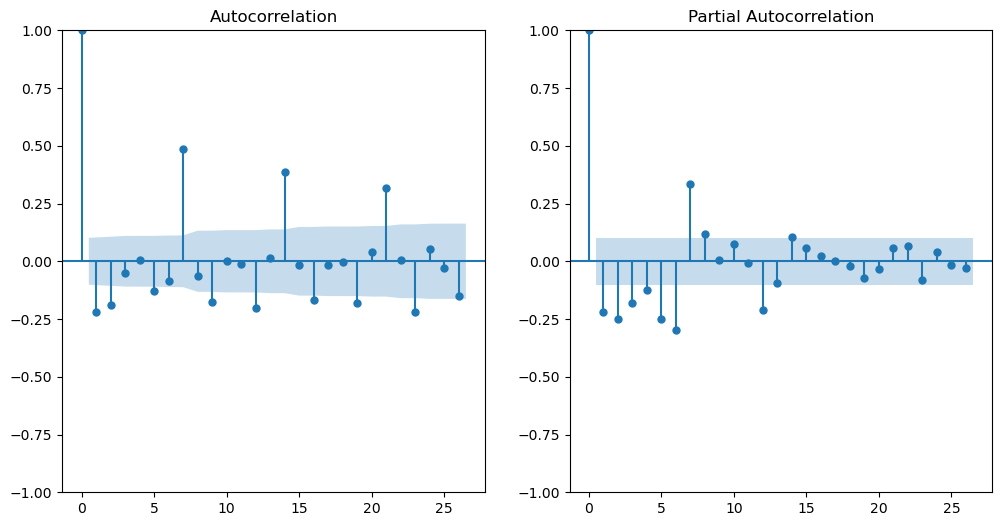

In [54]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plot_acf(daily_sales_diff, ax=plt.gca())
plt.subplot(122)
plot_pacf(daily_sales_diff, ax=plt.gca())
plt.show()

In [55]:
model = ARIMA(daily_sales['TotalPrice'], order=(2, 1, 2))
model_fit = model.fit()

# summary
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             TotalPrice   No. Observations:                  374
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -4179.066
Date:                Sat, 16 Nov 2024   AIC                           8368.131
Time:                        17:50:08   BIC                           8387.739
Sample:                    12-01-2022   HQIC                          8375.917
                         - 12-09-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5358      0.117     -4.572      0.000      -0.765      -0.306
ar.L2          0.1740      0.065      2.668      0.008       0.046       0.302
ma.L1         -0.0968      0.082     -1.182      0.2

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


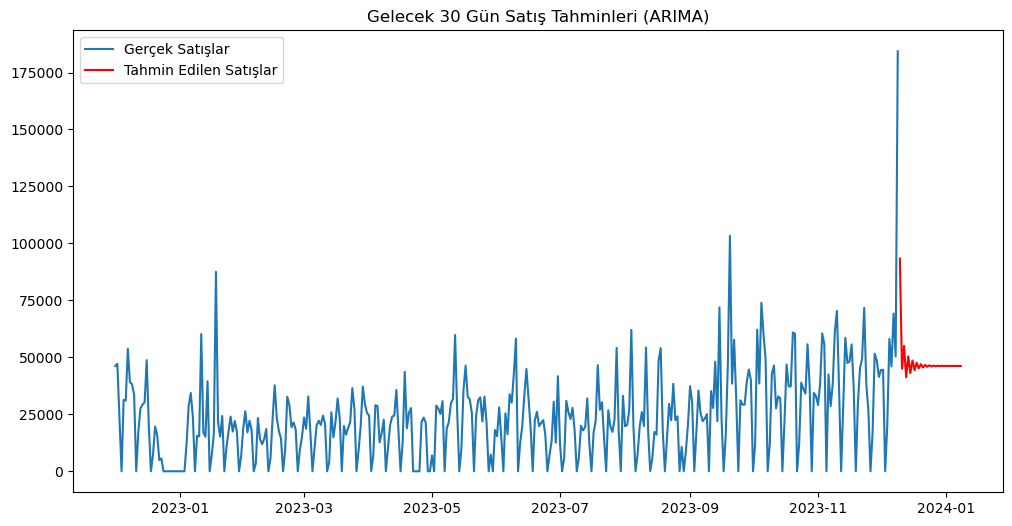

In [56]:
# Forecast the sales for the next 30 days
forecast = model_fit.forecast(steps=30)
forecast_dates = pd.date_range(start=daily_sales.index[-1], periods=30+1, freq='D')[1:]

# Visualize the forecast results
plt.figure(figsize=(12,6))
plt.plot(daily_sales.index, daily_sales['TotalPrice'], label='Gerçek Satışlar')
plt.plot(forecast_dates, forecast, label='Tahmin Edilen Satışlar', color='red')
plt.legend()
plt.title('Gelecek 30 Gün Satış Tahminleri (ARIMA)')
plt.show()


## LSTM

In [57]:
from sklearn.preprocessing import MinMaxScaler

# Normalize the 'TotalPrice' column
scaler = MinMaxScaler(feature_range=(0, 1))
sales_scaled = scaler.fit_transform(daily_sales[['TotalPrice']])


In [58]:
train_size = int(len(sales_scaled) * 0.8)
train_data, test_data = sales_scaled[:train_size], sales_scaled[train_size:]


def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 30 

X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)


In [59]:
import numpy as np

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


Epoch 1/100


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0473 - val_loss: 0.0392 - learning_rate: 0.0010
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0319 - val_loss: 0.0285 - learning_rate: 0.0010
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0300 - val_loss: 0.0339 - learning_rate: 0.0010
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0252 - val_loss: 0.0326 - learning_rate: 0.0010
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0198 - val_loss: 0.0295 - learning_rate: 0.0010
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0188 - val_loss: 0.0260 - learning_rate: 0.0010
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0159 - val_loss: 0.0265 - learning_rate: 0.0010
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0199 - val_loss: 0.0264 - learning_rate: 0.0010
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0140 - val_loss: 0.0264 - learning_rate: 0.0010
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s

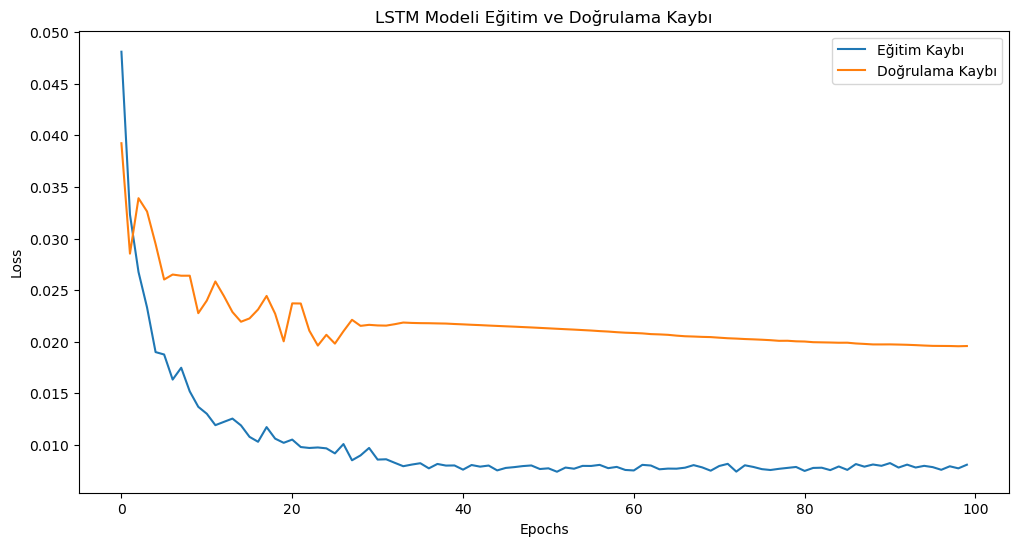

In [60]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers

# LSTM Modelini oluşturma
model = Sequential()

# İlk LSTM Katmanı
model.add(LSTM(units=100, return_sequences=True, input_shape=(time_step, 1), 
               kernel_regularizer=regularizers.l2(0.01)))  # L2 Regularization ekleyelim
model.add(Dropout(0.2))

# İkinci LSTM Katmanı
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.3))

# Üçüncü LSTM Katmanı
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.3))

# BatchNormalization ekleyelim (LSTM katmanından sonra)
model.add(BatchNormalization())

# Çıktı katmanı
model.add(Dense(units=1))

# Modeli derleme
model.compile(optimizer='adam', loss='mean_squared_error')

# EarlyStopping ve ReduceLROnPlateau callback'lerini ekleyelim
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)

# Modeli eğitme
history = model.fit(X_train, y_train, epochs=100, batch_size=32, 
                    validation_data=(X_test, y_test), 
                    callbacks=[reduce_lr])

# Eğitim sürecini görselleştirelim
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('LSTM Modeli Eğitim ve Doğrulama Kaybı')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


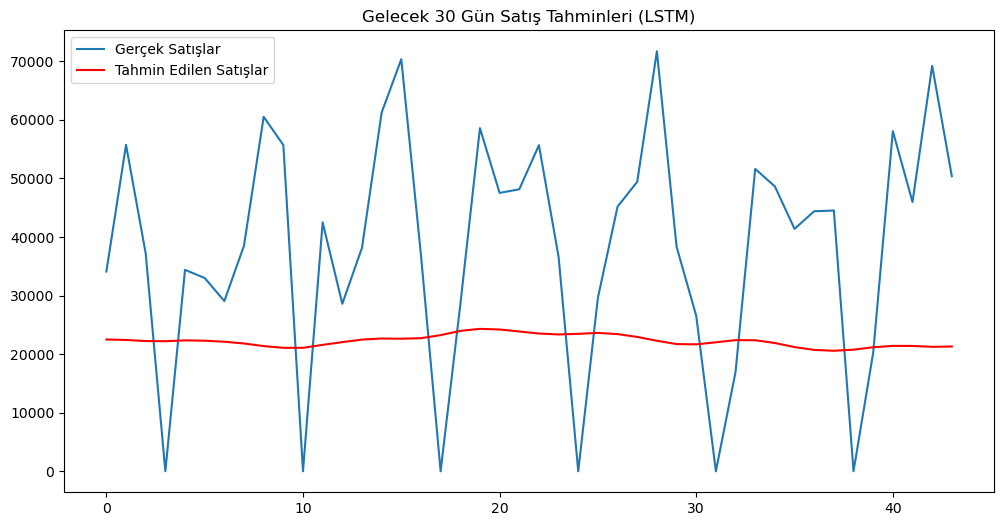

In [61]:
# Test verisiyle tahmin yapma
predicted_sales = model.predict(X_test)

# Tahminleri tersine çevirme (normalizasyonu geri alalım)
predicted_sales = scaler.inverse_transform(predicted_sales)
y_test_rescaled = scaler.inverse_transform([y_test])

# Grafikle gösterme
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(y_test_rescaled[0], label='Gerçek Satışlar')
plt.plot(predicted_sales, label='Tahmin Edilen Satışlar', color='red')
plt.legend()
plt.title('Gelecek 30 Gün Satış Tahminleri (LSTM)')
plt.show()


In [62]:
from sklearn.metrics import mean_squared_error
import math

# RMSE Hesaplama
rmse = math.sqrt(mean_squared_error(y_test_rescaled[0], predicted_sales))
print(f'Root Mean Squared Error (RMSE): {rmse}')


Root Mean Squared Error (RMSE): 25299.39948541122
